# Multimodal Housing Classification Pipeline

This notebook implements a multimodal deep learning pipeline to classify housing types based on both image data and tabular features.

Currently it uses an example Hybrid-model, this part will be exchanged for other models.

## Table of Contents

- [Section 1: Setup and Environment](#section-1-setup-and-environment)  
- [Section 2: Data Ingestion](#section-2-data-ingestion)  
- [Section 3: Preprocessing and Splitting](#section-3-preprocessing-and-splitting)  
- [Section 4: Dataset and DataLoader](#section-4-dataset-and-dataloader)  
- [Section 5: Multimodal Model Definition](#section-5-multimodal-model-definition)  
- [Section 6: Training & Validation Functions](#section-6-training--validation-functions)  
- [Section 7: Evaluation & Model Utilities](#section-7-evaluation--model-utilities)  
- [Section 8: Pipeline Execution](#section-8-pipeline-execution)

---

## Section 1: Setup and Environment

- Load necessary libraries for data handling, preprocessing, modeling, and visualization.
- Configure device (GPU/CPU).
- Load environment variables for paths (ensure `.env` file contains `FILE_PATH`).
- Define image directory and CSV data path.

Make sure you have the `.env` file properly configured with the base file path to your dataset and images.


In [1]:
# --- Section 1: Setup ---
import os
import pandas as pd
import numpy as np
from PIL import Image
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    cohen_kappa_score, 
    log_loss, 
    classification_report, 
    confusion_matrix
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Environment and Path Configuration
load_dotenv()
BASE_DIR = os.getenv('FILE_PATH')
if not BASE_DIR:
    raise ValueError("FILE_PATH environment variable not set. Please create a .env file and set it.")

DATA_PATH = os.path.join(BASE_DIR, 'Full_preprocessed_detailed_house.csv')
print(f"Base Directory: {BASE_DIR}")
print(f"Data CSV Path: {DATA_PATH}")


Using device: cuda
Base Directory: C:\Users\peta GamePC\Documents\UvA KI\matrixian\data\
Data CSV Path: C:\Users\peta GamePC\Documents\UvA KI\matrixian\data\Full_preprocessed_detailed_house.csv


## Section 2: Data Ingestion

- Load the dataset CSV file into a DataFrame.
- Print confirmation and dataset shape.


In [2]:
# --- Section 2: Data Ingestion ---
df = pd.read_csv(DATA_PATH)

merge_map = {
    'Bovenwoning': 'Bovenwoning/Benedenwoning/Maisonette',
    'Benedenwoning': 'Bovenwoning/Benedenwoning/Maisonette',
    'Maisonnette': 'Bovenwoning/Benedenwoning/Maisonette',
    'Corridorflat': 'Corridorflat/Galerijflat',
    'Galerijflat': 'Corridorflat/Galerijflat',
    'Hoekwoning': 'Hoekwoning/Eindwoning',
    'Eindwoning': 'Hoekwoning/Eindwoning',
    'Portiekflat': 'Portiekflat/Portiekwoning',
    'Portiekwoning': 'Portiekflat/Portiekwoning'

    # etc.
}

df['woningtype'] = df['woningtype'].map(merge_map).fillna(df['woningtype'])

print("Successfully loaded data. Shape:", df.shape)

Successfully loaded data. Shape: (7375, 15)


## Section 3: Preprocessing and Splitting

- Stratified splitting of dataset into train (60%), validation (20%), and test (20%) sets based on the target label (`woningtype`).
- Scale numeric features using training set statistics.
- One-hot encode categorical features using training set statistics.
- Clean and convert features to numeric types and handle missing values.
- Create full image paths and encode target labels with `LabelEncoder`.
- Define final tabular features for the model.


In [3]:
# --- Section 3: Preprocessing and Splitting ---

def preprocess_tabular_data(train_df, val_df, test_df):
    """Scales numeric columns and one-hot encodes categorical columns."""
    numeric_cols = ['opp_pand', 'oppervlakte', 'build_year']
    categorical_cols = ['build_type']
    
    # Scale numeric columns based on the training set
    scaler = StandardScaler()
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
    print("Numeric features scaled.")

    # One-hot encode categorical columns based on the training set
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(train_df[categorical_cols])
    
    cat_encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

    def encode_and_merge(df, encoder):
        encoded_data = encoder.transform(df[categorical_cols])
        encoded_df = pd.DataFrame(encoded_data, columns=cat_encoded_cols, index=df.index)
        return pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

    train_df = encode_and_merge(train_df, encoder)
    val_df = encode_and_merge(val_df, encoder)
    test_df = encode_and_merge(test_df, encoder)
    print("Categorical features one-hot encoded.")
    
    return train_df, val_df, test_df, numeric_cols, cat_encoded_cols


def clean_and_convert_features(df, feature_list):
    """Ensures all specified feature columns are numeric, filling NaNs."""
    cleaned_df = df.copy()
    for feature in feature_list:
        if feature in cleaned_df.columns:
            # Convert to numeric, coercing errors to NaN
            cleaned_df[feature] = pd.to_numeric(cleaned_df[feature], errors='coerce')
            # Fill any resulting NaNs with 0 (or a more suitable value like the mean)
            if cleaned_df[feature].isnull().sum() > 0:
                cleaned_df[feature] = cleaned_df[feature].fillna(0)
            # Ensure final type is float32 for PyTorch
            cleaned_df[feature] = cleaned_df[feature].astype('float32')
    return cleaned_df

def prepare_final_data(df, base_path):
    """Adds the full image path and encodes the 'woningtype' label."""
    # Build full image path
    df['img_path'] = df['frontview_url'].apply(lambda x: os.path.join(base_path, x))
    return df

# 1. Split the original dataframe
print("Splitting data into train (60%), validation (20%), and test (20%)...")
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['woningtype'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['woningtype'])

# 2. Preprocess tabular data (scaling and encoding)
train_df, val_df, test_df, numeric_cols, cat_encoded_cols = preprocess_tabular_data(train_df, val_df, test_df)

# 3. Define the full list of features for the model
tabular_features = numeric_cols + cat_encoded_cols
print(f"Total tabular features ({len(tabular_features)}): {tabular_features}")

# 4. Clean the dataframes to ensure all feature columns are numeric
print("Cleaning and converting features to numeric types...")
train_df = clean_and_convert_features(train_df, tabular_features)
val_df = clean_and_convert_features(val_df, tabular_features)
test_df = clean_and_convert_features(test_df, tabular_features)

# 5. Create image paths and encode labels
print("Preparing final data (image paths and labels)...")
train_df = prepare_final_data(train_df, BASE_DIR)
val_df = prepare_final_data(val_df, BASE_DIR)
test_df = prepare_final_data(test_df, BASE_DIR)

# Fit LabelEncoder on the full training 'woningtype' to create integer labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['woningtype'])
# Use the same encoder for validation and test sets
val_df['label'] = label_encoder.transform(val_df['woningtype'])
test_df['label'] = label_encoder.transform(test_df['woningtype'])

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

Splitting data into train (60%), validation (20%), and test (20%)...
Numeric features scaled.
Categorical features one-hot encoded.
Total tabular features (8): ['opp_pand', 'oppervlakte', 'build_year', 'build_type_Appartement', 'build_type_Hoekwoning', 'build_type_Tussen of geschakelde woning', 'build_type_Tweeonder1kap', 'build_type_Vrijstaande woning']
Cleaning and converting features to numeric types...
Preparing final data (image paths and labels)...
Train size: 4425 | Val size: 1475 | Test size: 1475
Number of classes: 10


## Section 4: Dataset and DataLoader

- Custom PyTorch `Dataset` class loads images and tabular features on-the-fly.
- Applies data augmentations only on training data (random horizontal flips and rotations) (SUBJECT TO CHANGE).
- Uses ImageNet normalization to match pretrained model input expectations.
- DataLoaders created with batch size of 32 and multi-threading support (adjust `NUM_WORKERS` accordingly).

**Notes:**
- You can adjust batch size and transforms to fit your hardware and data augmentation preferences.


In [ ]:
# --- Section 4: Dataset and DataLoader ---

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# Load SegFormer once
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
segformer = SegformerForSemanticSegmentation.from_pretrained(model_name).eval()

# Put model on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segformer.to(device)

# Get label map
id2label = segformer.config.id2label
building_class_ids = [idx for idx, label in id2label.items() if "building" in label.lower()]

class SegmentedHousingDataset(Dataset):
    def __init__(self, df, transform=None, segment=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.segment = segment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            # Load image
            img = Image.open(row['img_path']).convert('RGB')
            
            if self.segment:
                # Resize input image to 512x512 for model input
                img_resized = img.resize((512, 512))

                # Prepare inputs
                inputs = feature_extractor(images=img_resized, return_tensors="pt").to(device)

                with torch.no_grad():
                    output = segformer(**inputs).logits

                # Get predicted mask (shape: 128x128)
                mask = output.argmax(dim=1)[0].cpu().numpy()
                building_mask = np.isin(mask, building_class_ids).astype(np.uint8)  # shape: 128x128

                # Resize building mask up to 512x512 (image size) for elementwise masking
                building_mask_resized = Image.fromarray(building_mask).resize((512, 512), resample=Image.NEAREST)
                building_mask_resized = np.array(building_mask_resized)

                # Convert resized image to numpy
                img_np = np.array(img_resized)

                # Apply mask (broadcasting will now work: (512,512,3) * (512,512,1))
                img_np = img_np * building_mask_resized[:, :, None]

                # Convert back to PIL image
                img = Image.fromarray(img_np)


            # Apply transforms
            if self.transform:
                img = self.transform(img)

            label = torch.tensor(row['label'], dtype=torch.long)
            
            return img, label

        except Exception as e:
            # Handle image loading/segmentation errors
            # print(f"Error at index {idx} ({row['img_path']}): {e}")
            return self.__getitem__((idx + 1) % len(self.df))


# ImageNet normalization values, commonly used for pretrained models
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to expected input size
    transforms.ToTensor(),          # Convert to tensor [0,1]
    transforms.Normalize(           # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to expected input size
    transforms.ToTensor(),          # Convert to tensor [0,1]
    transforms.Normalize(           # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Initialize datasets
train_dataset = SegmentedHousingDataset(train_df, transform=train_transforms)
val_dataset = SegmentedHousingDataset(val_df, transform=val_transforms)
test_dataset = SegmentedHousingDataset(test_df, transform=val_transforms)

# Create DataLoaders
BATCH_SIZE = 32 # Adjusted for common GPU memory sizes, can be tuned
# Set num_workers=0 on Windows or for debugging, can be > 0 on Linux for performance
NUM_WORKERS = 0 if os.name == 'nt' else 2 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Datasets and DataLoaders created successfully.")

C:\Users\peta GamePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\peta GamePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\segformer\feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\peta GamePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureE

Datasets and DataLoaders created successfully.


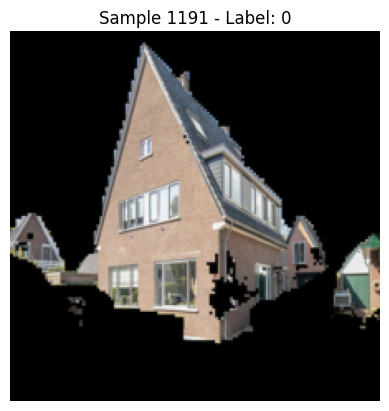

In [5]:
# test if segment works

train_dataset.segment = True

idx = 1191 

img_tensor, label = train_dataset[idx]

def unnormalize(tensor_img):
    img = tensor_img.numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    return np.clip(img, 0, 1)

img_np = unnormalize(img_tensor)

plt.imshow(img_np)
plt.title(f"Sample {idx} - Label: {label.item()}")
plt.axis("off")
plt.show()


## Section 5: Multimodal Model Definition

### ZET HIER JE MODEL

### Currently: 
- CNN backbone: ResNet18 pretrained on ImageNet, outputs 512-dim image features.
- Tabular MLP: Two-layer fully connected network with batch normalization and dropout.
- Fusion layer concatenates image and tabular embeddings before final classification head.

**Parameters to tune:**
- `tabular_input_dim`: Number of tabular features.
- Dropout rates and hidden layer sizes can be modified for regularization and capacity.


In [6]:
# --- Section 5: Model Definition ---

import torch.nn as nn
import torchvision.models as models

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)

        # Freeze base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

# inception_v3 = InceptionV3Classifier(num_classes=15)

## Section 6: Training & Validation Functions

This section defines functions for performing one epoch of training and validation for the multimodal model.

- **train_one_epoch**:  
  Executes a single epoch of training. The model is set to training mode.  
  For each batch:
  - Data is moved to the specified device (CPU/GPU).
  - Forward pass is performed to compute outputs.
  - Cross-entropy loss is computed and backpropagated.
  - Model parameters are updated via the optimizer.
  - Running loss and predictions are tracked for metrics calculation.
  
  Returns the average loss, accuracy, and weighted F1 score over the entire training dataset for the epoch.

- **validate_one_epoch**:  
  Executes a single epoch of validation without updating model parameters. The model is set to evaluation mode and gradient calculations are disabled.  
  For each batch:
  - Data is moved to the device.
  - Forward pass is performed and loss computed.
  - Predictions and losses are collected.
  
  Returns the average loss, accuracy, and weighted F1 score over the validation dataset.

In [7]:
# --- Section 6: Training & Validation Functions ---

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_acc, epoch_f1

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_acc, epoch_f1

## Section 7: Evaluation & Model Utilities

This section contains utility functions for evaluating the model’s performance, saving, and loading the model weights.

- **evaluate_model**:  
  Runs inference on a dataset and prints a detailed classification report along with a confusion matrix heatmap to visualize performance across classes.

- **save_model**:  
  Saves the model’s state dictionary to a `models/` directory. If the directory does not exist, it will be created automatically.  
  To avoid overwriting, if a model file with the given name already exists, a numeric suffix (`_1`, `_2`, etc.) is appended to the filename.

- **load_model**:  
  Loads the saved model weights from a specified path, moves the model to the appropriate device (CPU or GPU), and sets it to evaluation mode.


In [8]:
# --- Section 7: Evaluation & Model Utilities ---

def evaluate_model(model, dataloader, device, class_names):
    """
    Evaluates the model on a given dataloader and prints a comprehensive report
    including individual metrics, a classification report, and a confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
            # Get probabilities for log_loss
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            
            # Get predictions for other metrics
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # --- Calculate and Print Individual Metrics ---
    print("\n--- Evaluation Metrics ---")
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    kappa = cohen_kappa_score(all_labels, all_preds)
    logloss = log_loss(all_labels, all_probs)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # --- Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # --- Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



def save_model(model, filename='trained_model.pth'):
    models_dir = 'models'
    os.makedirs(models_dir, exist_ok=True)
    base_path = os.path.join(models_dir, filename)

    # If file exists, add suffix
    if os.path.exists(base_path):
        base_name, ext = os.path.splitext(filename)
        suffix = 1
        while True:
            new_filename = f"{base_name}_{suffix}{ext}"
            new_path = os.path.join(models_dir, new_filename)
            if not os.path.exists(new_path):
                base_path = new_path
                break
            suffix += 1

    torch.save(model.state_dict(), base_path)
    print(f"Model saved to {base_path}")
    return base_path



def load_model(model_architecture, path, device):
    model_architecture.load_state_dict(torch.load(path, map_location=device))
    model_architecture.to(device)
    model_architecture.eval()
    print(f"Model loaded from {path} and set to evaluation mode.")
    return model_architecture

## Section 8: Pipeline Execution

- Initialize model, criterion (cross entropy), and optimizer (Adam). (SUBJECT TO CHANGE)
- Run training/validation for specified epochs.
- Save best model weights.
- Load best model for final testing and evaluation.

**User Options:**
- Modify `NUM_EPOCHS`, learning rate (`lr`), and batch size (`BATCH_SIZE`) to fit your needs.
- You can replace `MultimodalHousingClassifier` with your custom model if desired.


In [9]:
# --- Section 8: Main Pipeline Execution ---
print("🚀 Starting full pipeline execution...")

# 1. Initialize Model
tabular_input_dim = len(tabular_features)
num_classes = len(label_encoder.classes_)
model = ResNet50Classifier(num_classes=num_classes).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")

# 2. Define Loss, Optimizer, and Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
NUM_EPOCHS = 10 # You can adjust this
best_val_f1 = 0
BEST_MODEL_PATH = "best_housing_classifier.pth"

print(f"Training for {NUM_EPOCHS} epochs...")

# 3. Run Training and Validation Loop
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
    
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch} Summary:")
    print(f"  Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        model_path = save_model(model, BEST_MODEL_PATH)
        print(f"🎉 New best model saved with F1 score: {best_val_f1:.4f}")

print("\n✅ Training complete.")

🚀 Starting full pipeline execution...


C:\Users\peta GamePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\peta GamePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model initialized with 1,054,218 trainable parameters.
Training for 10 epochs...

--- Epoch 1/10 ---


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [ ]:
# 4. Evaluate the Best Model on the Test Set
print(f"\n📊 Loading best model from '{model_path}' and evaluating on the test set...")
# Re-initialize a fresh model architecture
final_model = ResNet50Classifier(num_classes=num_classes)
# Load the saved state dict
final_model = load_model(final_model, model_path, device)


class_names = list(label_encoder.classes_)
evaluate_model(final_model, test_loader, device, class_names=class_names)

print("\n✅ Pipeline finished successfully!")